<a href="https://colab.research.google.com/github/sujitpal/nlp-deeplearning-ai-examples/blob/master/04_03_t5_postagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Answering with T5

This notebook fine tunes a T5 (Text To Text Transfer Transformer) model to do trivia question answering. The [Google AI Blog post](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html) describes T5 in more detail.

Here we will use the [Huggingface Transformer Library](https://huggingface.co/transformers/index.html) to instantiate a `t5-small` pre-trained model and fine tune it against approximate 23k question answer pairs from the [FreebaseQA](https://github.com/kelvin-jiang/FreebaseQA) dataset.

In [1]:
!pip install transformers

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from transformers import T5Tokenizer, T5ForConditionalGeneration

%matplotlib inline

## Load pre-trained model and tokenizer

In [3]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)

## Inference with Pre-trained T5

We run some T5 commands such as `summarize:`, `translate English to German:` and `translate English to French:` to get an idea of the calling pattern.

In [4]:
text = """
Albert Einstein (14 March 1879 – 18 April 1955) was a German-born theoretical physicist 
who developed the theory of relativity, one of the two pillars of modern physics 
(alongside quantum mechanics) . His work is also known for its influence on the philosophy 
of science . He is best known to the general public for his mass–energy equivalence 
formula E = mc2, which has been dubbed "the world's most famous equation" . He received 
the 1921 Nobel Prize in Physics "for his services to theoretical physics, and especially 
for his discovery of the law of the photoelectric effect", a pivotal step in the 
development of quantum theory.
"""
input_ids = tokenizer("summarize: {:s} ".format(text), 
                      return_tensors="pt").input_ids  # Batch size 1
outputs = model.generate(input_ids)
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(outputs[0]))

'Albert Einstein was a German-born theoretical physicist . he'

In [5]:
text = """
Alice in Wonderland is a very popular children's novel in the fantasy genre .
"""
input_ids = tokenizer("translate English to German: {:s} ".format(text),
                      return_tensors="pt").input_ids
outputs = model.generate(input_ids)
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(outputs[0]))

'Alice in Wonderland ist ein sehr beliebter Kinderroman im Fantasy-Genre '

In [6]:
input_ids = tokenizer("translate English to French: {:s} ".format(text),
                      return_tensors="pt").input_ids
outputs = model.generate(input_ids)
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(outputs[0]))

"Alice in Wonderland est un roman très populaire d'enfants dans le genre fantas"

## Fine tuning T5 for trivia question answering

Most QA datasets are quite large, such as TriviaQA and Natural Questions. We are going to use [kelvin-jiang/FreebaseQA](https://github.com/kelvin-jiang/FreebaseQA). There are around 4000 questions and answers in the `dev` split, we will use that for fine-tuning.

### Data

In [7]:
!git clone https://github.com/kelvin-jiang/FreebaseQA.git

fatal: destination path 'FreebaseQA' already exists and is not an empty directory.


In [8]:
def parse_json_data(filepath):
  question_texts, answer_texts = [], []
  with open(filepath, "r") as f:
    train_json = json.loads(f.read())
  for question in train_json["Questions"]:
    question_texts.append(question["ProcessedQuestion"])
    answer_texts.append(question["Parses"][0]["Answers"][0]["AnswersName"][0])
  return question_texts, answer_texts

question_train, answer_train = parse_json_data("FreebaseQA/FreebaseQA-train.json")
question_test, answer_test = parse_json_data("FreebaseQA/FreebaseQA-eval.json")

len(question_train), len(answer_train), len(question_test), len(answer_test)

(20358, 20358, 3996, 3996)

### Model Training

In [9]:
def get_batch(iterable, bs=1):
    n = len(iterable)
    for ndx in range(0, n, bs):
        yield iterable[ndx : min(ndx + bs, n)]

list(get_batch([1, 2, 3, 4, 5, 6, 7, 8], bs=3))

[[1, 2, 3], [4, 5, 6], [7, 8]]

In [10]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-5

In [11]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)

In [12]:
losses = []
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, NUM_EPOCHS+1):
  for b in get_batch(list(zip(question_train, answer_train)), BATCH_SIZE):

    question_batch = ["question: {:s} ".format(q) for q, a in b]
    answer_batch = [a for q, a in b]

    inputs = tokenizer(question_batch, return_tensors="pt", 
                       padding=True, truncation=True)
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    labels = tokenizer(answer_batch, return_tensors="pt", 
                       padding=True, truncation=True).input_ids

    input_ids = input_ids.to(dev)
    attention_mask = attention_mask.to(dev)
    labels = labels.to(dev)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().cpu().numpy())

  print("epoch {:d}, loss: {:.5f}".format(epoch, losses[-1]))

epoch 1, loss: 1.74862
epoch 2, loss: 1.53207
epoch 3, loss: 1.34242
epoch 4, loss: 1.11768
epoch 5, loss: 0.95690
epoch 6, loss: 0.82033
epoch 7, loss: 0.67802
epoch 8, loss: 0.52463
epoch 9, loss: 0.46084
epoch 10, loss: 0.41044


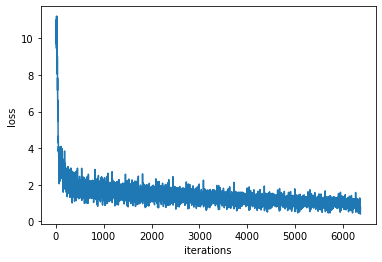

In [13]:
plt.plot(np.arange(len(losses))+1, losses)
plt.xlabel("iterations")
plt.ylabel("loss")

_ = plt.show()

### Evaluation

The fine tuning has resulted in the model learning the general style of response to give, but the predicted answers don't match with the label answers.

According to [this T5 training colab notebook from Google Research](https://colab.research.google.com/github/google-research/text-to-text-transfer-transformer/blob/master/notebooks/t5-trivia.ipynb), trivia question answering is a hard problem even with a powerful model such as T5. For comparison, the 11B T5 model achieves 25% and 35% accuracy on TriviaQA and Natural Questions datasets, and the 3B T5 model achieves 29% and 23% accuracy respectively. These models seem to be trained for at least 25k steps.

Both models are comparatively larger and more complex than the one we are using (`t5-small`), and the TriviaQA and NQ datasets are also much larger than our FreebaseQA dataset. We train our model for fewer iterations as well, only 6k steps.

In [14]:
answer_preds = []
num_batches = 0
for b in get_batch(list(zip(question_test, answer_test))):
  if num_batches % 100 == 0:
    print("{:d} batches complete".format(num_batches))
  question_batch = ["question: {:s} ".format(q) for q, a in b]

  input_ids = tokenizer(question_batch, return_tensors="pt",
                        padding=True, truncation=True).input_ids
  input_ids = input_ids.to(dev)
  outputs = model.generate(input_ids)
  for output in outputs:
    answer_preds.append(tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(output)))
  num_batches += 1

print("{:d} batches complete, COMPLETE".format(num_batches))

0 batches complete
100 batches complete
200 batches complete
300 batches complete
400 batches complete
500 batches complete
600 batches complete
700 batches complete
800 batches complete
900 batches complete
1000 batches complete
1100 batches complete
1200 batches complete
1300 batches complete
1400 batches complete
1500 batches complete
1600 batches complete
1700 batches complete
1800 batches complete
1900 batches complete
2000 batches complete
2100 batches complete
2200 batches complete
2300 batches complete
2400 batches complete
2500 batches complete
2600 batches complete
2700 batches complete
2800 batches complete
2900 batches complete
3000 batches complete
3100 batches complete
3200 batches complete
3300 batches complete
3400 batches complete
3500 batches complete
3600 batches complete
3700 batches complete
3800 batches complete
3900 batches complete
3996 batches complete, COMPLETE


In [15]:
data = []
for question, answer, predicted in zip(question_test, answer_test, answer_preds):
  data.append((question, answer, predicted))

results_df = pd.DataFrame(data, columns=["question", "label_ans", "predicted_ans"])
results_df.head(20)

,question,label_ans,predicted_ans
0,who is the female presenter of the channel 4 q...,sandi toksvig,john faye
1,"who produced the film 12 angry men, which was ...",henry fonda,henry bing
2,who directed the films; the fisher king (1991)...,terry gilliam,john bilbourn
3,who directed the 2013 film 12 years a slave,steve mcqueen,john billy
4,which british athlete won the 100 m. at the 19...,harold abrahams,joe biden
5,which country hosted the 1936 summer olympic g...,germany,canada
6,who declared the 1936 summer olympic games ope...,adolf hitler,john billy
7,the chicago bears defeated which team 73-0 in ...,washington redskins,swansea city
8,where were the 1952 olympic games held,helsinki,sylvia bambi
9,which us author won the 1953 pulitzer prize fo...,ernest hemingway,john steinbeck
